In [ ]:
!pip install datasets

In [3]:
%load_ext autoreload
%autoreload 2
# %load_ext tensorboard
%load_ext matplotlib
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The matplotlib module is not an IPython extension.


In [4]:
import torch
import safetensors
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from torchvision.transforms import v2
from model import VQVAE
import math
import matplotlib.pyplot as plt

/Users/vidursatija/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vidursatija/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
m = VQVAE(hidden_size=256, num_embeddings=512, commitment_beta=1.0).to(device='mps', dtype=torch.float32)
safetensors.torch.load_model(m, 'model-15600.safetensors', device='mps')

(set(), [])

In [7]:
test_ds = load_dataset('uoft-cs/cifar100')['test']
print(test_ds)

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 266382.82 examples/s]

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 10000
})


In [13]:
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]
preproc = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=img_mean, std=img_std),  # typically from ImageNet
])

def create_data_collator():
    def data_collator(examples):
        # examples = {"img"}
        cpu_dict = {
            "x": torch.stack([preproc(ex["img"].convert('RGB')) for ex in examples]),
        }

        return cpu_dict

    return data_collator


dc = create_data_collator()

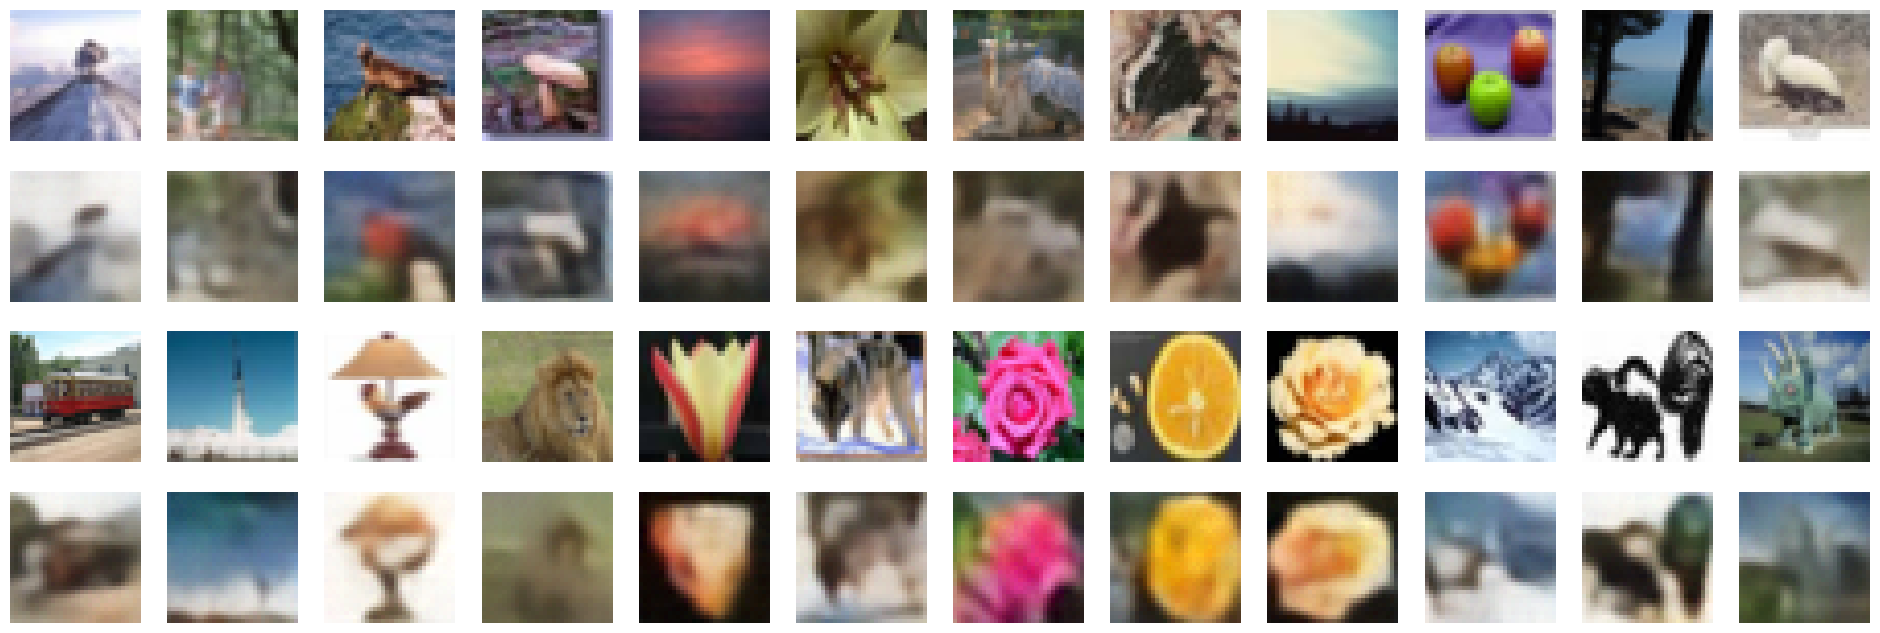

In [23]:
# now we take a batch of 8 images
# pass to data_collator
# then pass to model
# then denormalize and show the images
N_IMAGES = 24
first_batch = test_ds.select(range(N_IMAGES))
batch = dc(first_batch)
# move to cuda
batch = {k: v.to('mps') for k, v in batch.items()}
# pass through model
reconstructions = m(**batch)
decoded_images = reconstructions['decoded']
# denormalize and move to numpy
np_img_mean = torch.tensor(img_mean).view(1, 3, 1, 1).to('mps')
np_img_std = torch.tensor(img_std).view(1, 3, 1, 1).to('mps')
decoded_images = decoded_images * np_img_std + np_img_mean
# clamp to [0, 1]
decoded_images = torch.clamp(decoded_images, 0, 1)
# tranpose to batch, w, h, 3 and move to cpu and numpy
decoded_images = decoded_images.permute(0, 2, 3, 1).detach().cpu().numpy()
# show side by side -- on the left the original image, right decoded. figsize should be determined by N_IMAGES
fig, ax = plt.subplots(4, N_IMAGES // 2, figsize=(N_IMAGES // 2 * 2, 4*2))
for j in range(2):
    for i in range(N_IMAGES // 2):
        img_idx = i + j * (N_IMAGES // 2)
        ax[2*j, i].imshow(first_batch['img'][img_idx])
        ax[2*j + 1, i].imshow(decoded_images[img_idx])
        ax[2*j, i].axis('off')
        ax[2*j + 1, i].axis('off')
plt.show()